In [3]:
from prophet import Prophet
from yahooquery import Ticker
import pandas as pd
from datetime import datetime
import pandas_ta as ta
import plotly.express as px
import plotly.graph_objs as go
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.model_selection import train_test_split

In [20]:
# Name by which it is represented on the stock exchange.
symbol = "USDBRL=X"

# Query stock in yahoo finance
stock = Ticker(symbol)

# Get 48 months data for enough sample terms
history = stock.history(period="120mo")

# Let only date as index
history.reset_index(level=["symbol"], inplace=True)

# Create date column
history['date'] = history.index

# Reindex data using a DatetimeIndex
history.set_index(pd.DatetimeIndex(history.index), inplace=True)

# select features that have interest to us
data = history[['date','adjclose']].copy()

# use technical analyses using 21 one days and append to our dataset
data.ta.ema(close='adjclose', length=21, append=True)

# Drop empty values
data.dropna(inplace=True)
data

,date,adjclose,EMA_21
date,,,
2013-07-01 01:00:00+01:00,2013-07-01,2.1892,2.162224
2013-07-02 01:00:00+01:00,2013-07-02,2.2231,2.167758
2013-07-03 01:00:00+01:00,2013-07-03,2.2472,2.174980
2013-07-04 01:00:00+01:00,2013-07-04,2.2634,2.183018
2013-07-05 01:00:00+01:00,2013-07-05,2.2460,2.188744
...,...,...,...
2023-05-29 01:00:00+01:00,2023-05-29,4.9928,4.980979
2023-05-30 01:00:00+01:00,2023-05-30,5.0181,4.984353
2023-05-31 01:00:00+01:00,2023-05-31,5.0348,4.988939


In [21]:
#Plot
fig = px.line(data, x='date', y='adjclose')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [22]:
# Add all dataset as training model
df_train = data[['date','adjclose','EMA_21']].rename(columns={"date": "ds", "adjclose": "y"})
df_train['ds'] = pd.to_datetime(df_train['ds']).dt.tz_localize(None)
# Fit model
m = Prophet(daily_seasonality=True,changepoint_prior_scale=1.00)

# Train 
m.fit(df_train)

# Get dates 30 days in the future
future = m.make_future_dataframe(periods=30)

# Drop weekends
future['day'] =  future['ds'].dt.weekday
future = future[future['day'] <=4]

# Predict dates
forecast = m.predict(future)

15:04:50 - cmdstanpy - INFO - Chain [1] start processing
15:04:51 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Plot linear regression result
fig = go.Figure([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=forecast['ds'], y=df_train['EMA_21'], name='EMA', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [24]:
# Get all predictions
pred_df = forecast[forecast['ds'] > datetime.today()][['ds','yhat']]

# Reset Index
pred_df.reset_index(inplace=True)

# Drop index column
pred_df.drop(labels='index', axis=1,inplace=True)

# Rename columns
pred_df.rename(columns={'ds': 'date', 'yhat': 'predicted price'}, inplace=True)

# Show first elements
pred_df.head()

,date,predicted price
0,2023-06-02 19:04:34,4.963942
1,2023-06-05 19:04:34,4.932317
2,2023-06-06 19:04:34,4.905401
3,2023-06-07 19:04:34,4.912774
4,2023-06-08 19:04:34,4.890157


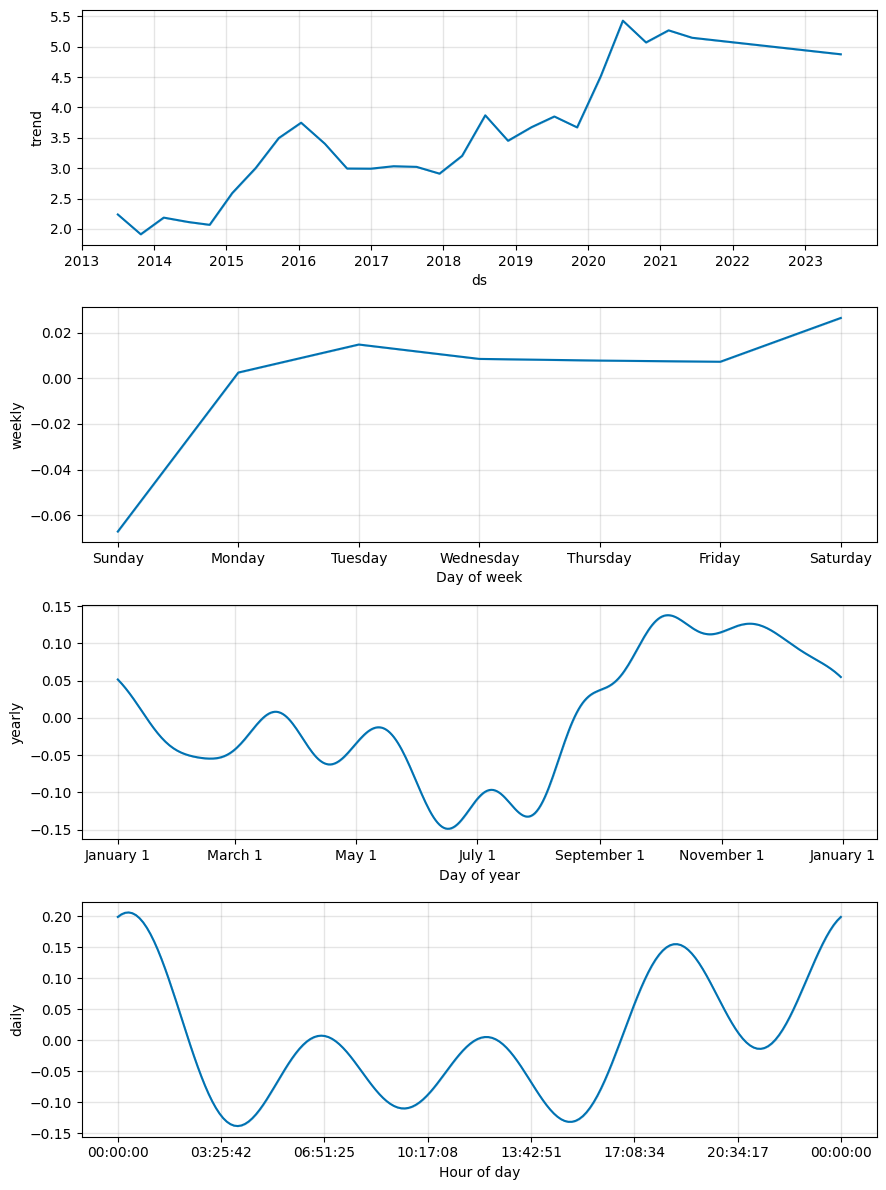

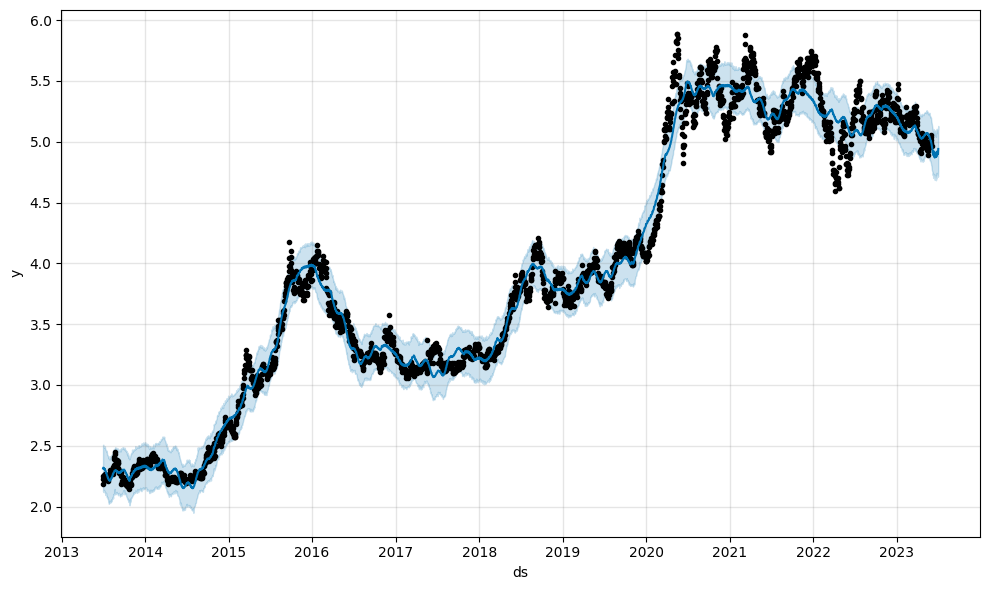

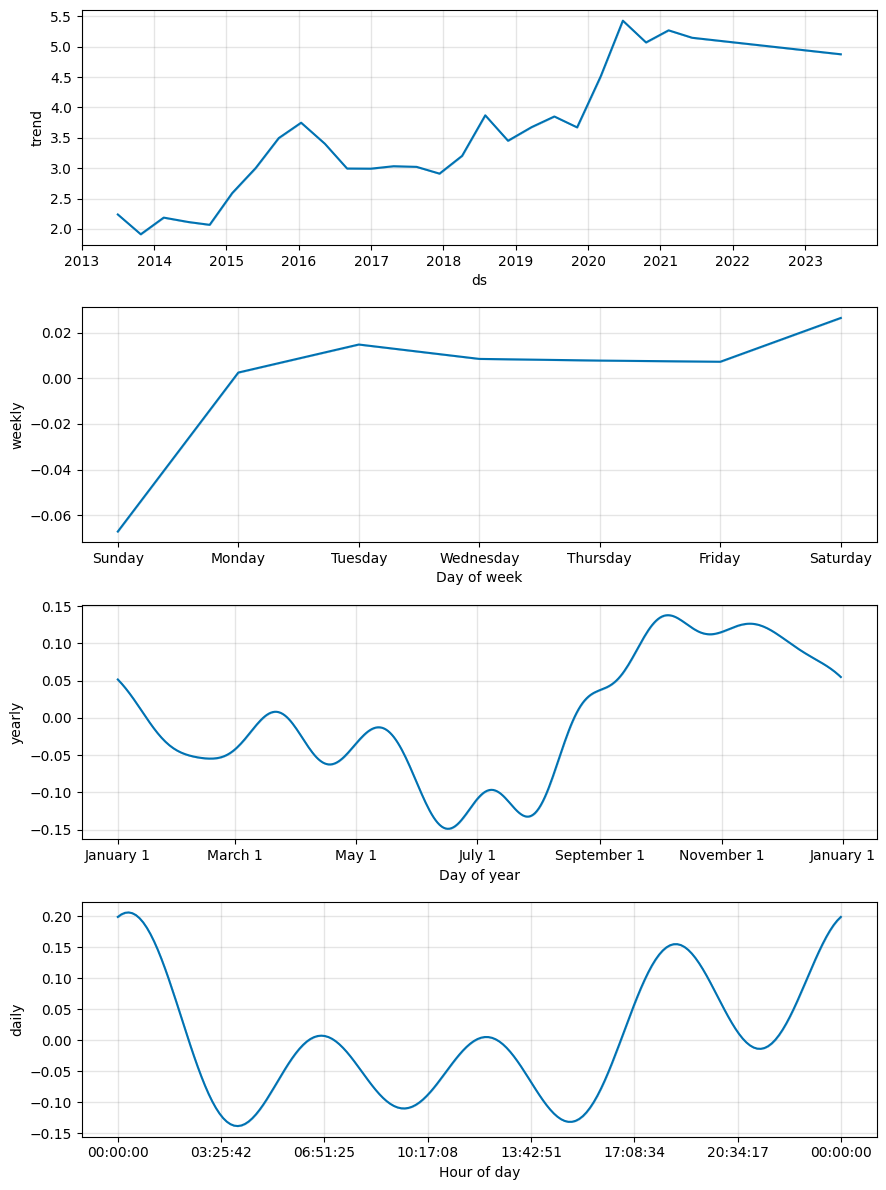

In [25]:
m.plot(forecast)
m.plot_components(forecast)

In [12]:
# execute cross validation

# reference
# https://facebook.github.io/prophet/docs/diagnostics.html#:~:text=Cross%20validation,up%20to%20that%20cutoff%20point.

df_cv = cross_validation(m, initial='720 days', period='30 days', horizon = '365 days')

# visualize data
print(df_cv.head())

# measure performance
df_p = performance_metrics(df_cv)
print(df_p)

  0%|          | 0/85 [00:00<?, ?it/s]13:52:35 - cmdstanpy - INFO - Chain [1] start processing
13:52:35 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/85 [00:00<00:31,  2.66it/s]13:52:35 - cmdstanpy - INFO - Chain [1] start processing
13:52:36 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/85 [00:00<00:32,  2.58it/s]13:52:36 - cmdstanpy - INFO - Chain [1] start processing
13:52:36 - cmdstanpy - INFO - Chain [1] done processing
  4%|▎         | 3/85 [00:01<00:34,  2.37it/s]13:52:36 - cmdstanpy - INFO - Chain [1] start processing
13:52:37 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 4/85 [00:01<00:34,  2.34it/s]13:52:37 - cmdstanpy - INFO - Chain [1] start processing
13:52:37 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 5/85 [00:02<00:34,  2.33it/s]13:52:37 - cmdstanpy - INFO - Chain [1] start processing
13:52:37 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 6/85 [00:02<00:33,  2.38it/s]13:52:38

                   ds      yhat  yhat_lower  yhat_upper       y  \
0 2015-07-10 01:00:00  3.187989    3.152212    3.223703  3.2211   
1 2015-07-13 01:00:00  3.201196    3.166696    3.237566  3.1556   
2 2015-07-14 01:00:00  3.211378    3.175690    3.248578  3.1312   
3 2015-07-15 01:00:00  3.212493    3.173773    3.251705  3.1365   
4 2015-07-16 01:00:00  3.215919    3.176074    3.254529  3.1356   

               cutoff  
0 2015-07-09 17:49:38  
1 2015-07-09 17:49:38  
2 2015-07-09 17:49:38  
3 2015-07-09 17:49:38  
4 2015-07-09 17:49:38  
           horizon       mse      rmse       mae      mape     mdape  \
0 36 days 07:10:22  0.109774  0.331321  0.231331  0.052094  0.038537   
1 37 days 06:10:22  0.109536  0.330962  0.231546  0.052204  0.038758   
2 37 days 07:10:22  0.111992  0.334652  0.234452  0.052889  0.039499   
3 38 days 06:10:22  0.111804  0.334371  0.234747  0.053009  0.039895   
4 38 days 07:10:22  0.114507  0.338389  0.237772  0.053707  0.040402   

      smape  coverag

In [15]:
print(df_cv)

                       ds      yhat  yhat_lower  yhat_upper       y  \
0     2015-07-10 01:00:00  3.187989    3.152212    3.223703  3.2211   
1     2015-07-13 01:00:00  3.201196    3.166696    3.237566  3.1556   
2     2015-07-14 01:00:00  3.211378    3.175690    3.248578  3.1312   
3     2015-07-15 01:00:00  3.212493    3.173773    3.251705  3.1365   
4     2015-07-16 01:00:00  3.215919    3.176074    3.254529  3.1356   
...                   ...       ...         ...         ...     ...   
22119 2023-05-29 01:00:00  4.881037    2.425092    7.017873  4.9928   
22120 2023-05-30 01:00:00  4.882424    2.454022    7.130951  5.0181   
22121 2023-05-31 01:00:00  4.871718    2.444001    7.177938  5.0348   
22122 2023-06-01 01:00:00  4.861965    2.357839    7.164649  5.0548   
22123 2023-06-02 17:49:38  4.598110    2.110506    6.818449  4.9627   

                   cutoff  
0     2015-07-09 17:49:38  
1     2015-07-09 17:49:38  
2     2015-07-09 17:49:38  
3     2015-07-09 17:49:38  
4     2